### Imports

In [3]:
import os
import json
import random
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pycocotools.coco import COCO


from PIL import Image
from random import shuffle
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Loading/Pre-processing data

In [29]:
# Setup directory paths
#you need to manually set this to the kaggle dir based on your file strucutre
base_dir = r'C:\Users\Michael Yoo\Desktop\NeuralNet\nnfinal-proj\kaggle'

# Setup paths using the base directory
train_images_dir = os.path.join(base_dir, 'train2014', 'train2014')
train_annotations_dir = os.path.join(base_dir, 'annotations_trainval2014', 'annotations')
val_images_dir = os.path.join(base_dir, 'val2017', 'val2017')
val_annotations_dir = os.path.join(base_dir, 'annotations_trainval2017', 'annotations')



# Initialize COCO api for instance annotations
coco_train = COCO(os.path.join(train_annotations_dir, 'instances_train2014.json'))
coco_val = COCO(os.path.join(val_annotations_dir, 'instances_val2017.json'))

import tensorflow as tf
from pycocotools.coco import COCO
import numpy as np
import os



def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # Normalize to [0, 1]
    return image

def fetch_dataset(coco, image_dir, batch_size=32):
    imgIds = coco.getImgIds()  # Get all image IDs

    def generator():
        for imgId in imgIds:
            img_dict = coco.loadImgs(imgId)[0]
            image_path = os.path.join(image_dir, img_dict['file_name'])
            image = load_and_preprocess_image(image_path)
            annIds = coco.getAnnIds(imgIds=imgId, iscrowd=None)
            anns = coco.loadAnns(annIds)
            if anns:
                for ann in anns:
                    bbox = [ann['bbox'][0] / img_dict['width'], ann['bbox'][1] / img_dict['height'],
                            ann['bbox'][2] / img_dict['width'], ann['bbox'][3] / img_dict['height']]
                    category = ann['category_id']
                    # One-hot encode the category; adjust the depth according to the number of categories
                    one_hot_category = tf.one_hot(category - 1, depth=80)  # Subtract 1 if category IDs start from 1
                    yield image, {'bbox': bbox, 'class_output': one_hot_category}

    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        {
            'bbox': tf.TensorSpec(shape=(4,), dtype=tf.float32),
            'class_output': tf.TensorSpec(shape=(80,), dtype=tf.float32)
        }
    )
    
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset




# Prepare datasets
train_dataset = fetch_dataset(coco_train, train_images_dir, batch_size=32)
val_dataset = fetch_dataset(coco_val, val_images_dir, batch_size=32)

def viewdataset(dataset, name="Dataset"):
    for images, labels in dataset.take(1):
        print(f"{name} contains data.")
        print(f"Sample image shape: {images.shape}")
        print(f"Sample bounding box: {labels['bbox'].numpy()}")
        print(f"Sample category (one-hot): {labels['class_output'].numpy()}")
        break
    else:
        print(f"{name} is empty.")

# Check the modified train and validation datasets
viewdataset(train_dataset, "Train Dataset")
viewdataset(val_dataset, "Validation Dataset")

loading annotations into memory...
Done (t=15.63s)
creating index...
index created!
loading annotations into memory...
Done (t=10.64s)
creating index...
index created!
Train Dataset contains data.
Sample image shape: (32, 224, 224, 3)
Sample bounding box: [[0.9542969  0.3820283  0.04570312 0.46292454]
 [0.84379166 0.6782187  0.03710417 0.08254687]
 [0.97646874 0.5444965  0.00651562 0.02250586]
 [0.17720833 0.6365156  0.02895833 0.02895313]
 [0.72858334 0.4904375  0.01583333 0.02204688]
 [0.661875   0.60141665 0.2425     0.14733334]
 [0.0931875  0.41018823 0.00946875 0.03891765]
 [0.3050625  0.43595833 0.07078125 0.296625  ]
 [0.8644355  0.77821875 0.08233871 0.22178125]
 [0.29816666 0.02271875 0.3769375  0.15609375]
 [0.7505625  0.13671875 0.2494375  0.25615624]
 [0.5831875  0.4410773  0.0236875  0.0841452 ]
 [0.10314583 0.3903125  0.30897915 0.03379688]
 [0.29971874 0.2328125  0.07629687 0.03814583]
 [0.65367186 0.33775    0.1779375  0.14116667]
 [0.55784374 0.21275058 0.44215626 0.65

### build da model

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2


# Base Feature Extractor
# Input layer
input_layer = Input(shape=(224, 224, 3))

# Use MobileNetV2 as the feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the base model
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
    layer.trainable = False

# Classification Head
x = Conv2D(512, (3, 3), activation='relu', padding='same')(base_model.output)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
class_head = Dense(80, activation='softmax', name='class_output')(x)  # Class prediction

#Region Proposal Network (simplified)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(base_model.output)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
bbox_head = Dense(4, activation='sigmoid', name='bbox')(x)  # Predicting 4 coordinates

model = Model(inputs=input_layer, outputs=[bbox_head, class_head])

from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss={
        'bbox': 'mse',
        'class_output': 'categorical_crossentropy'
    },
    metrics={
        'bbox': ['mse'],
        'class_output': ['accuracy']
    }
)

c:\Temp\ipykernel_9916\2348556898.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)


### Compile and train

In [31]:
# Print out shapes of target and output tensors
for images, labels in train_dataset.take(1):
    print("Shapes of target tensors:")
    print("Bounding Box:", labels['bbox'].shape)
    print("Class Output:", labels['class_output'].shape)
    break

for images, labels in val_dataset.take(1):
    print("Shapes of target tensors:")
    print("Bounding Box:", labels['bbox'].shape)
    print("Class Output:", labels['class_output'].shape)
    break


history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)
model.save('imgbbox+class_model.keras')

Shapes of target tensors:
Bounding Box: (32, 4)
Class Output: (32, 80)
Shapes of target tensors:
Bounding Box: (32, 4)
Class Output: (32, 80)
Epoch 1/5
      9/Unknown 35s 2s/step - bbox_mse: 0.1331 - class_output_accuracy: 0.1741 - loss: 5.3186

KeyboardInterrupt: 

### Display predictions

In [14]:

from tensorflow.keras.models import load_model

model_path = r'C:\Users\Michael Yoo\Desktop\NeuralNet\nnfinal-proj\imgbbox+class_model.keras'
model = load_model(model_path)

print("Model loaded successfully!")

Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Top predicted categories and their probabilities:
keyboard: 0.9689
sandwich: 0.0311
person: 0.0000
chair: 0.0000
clock: 0.0000


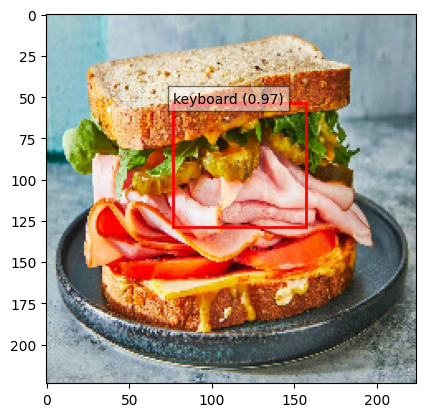

In [25]:

import matplotlib.patches as patches

#replace the path with your local path on your machine
image_path = r'C:\Users\Michael Yoo\Desktop\NeuralNet\nnfinal-proj\sandwich.jpg'

processed_image = load_and_preprocess_image(image_path)
processed_image = np.expand_dims(processed_image, axis=0)

#predict
predictions = model.predict(processed_image)
bbox_pred, class_pred = predictions

#get output
bbox_pred = bbox_pred[0]
class_pred = class_pred[0]

#get top probabilities
top_indices = np.argsort(class_pred)[-5:][::-1]

index_to_coco_id = {i: id for i, id in enumerate(sorted(coco_train.getCatIds()))}
top_category_ids = [index_to_coco_id[idx] for idx in top_indices]
top_categories = [coco_train.loadCats(id)[0]['name'] for id in top_category_ids]
top_probabilities = class_pred[top_indices]

print("Top predicted categories and their probabilities:")
for category, probability in zip(top_categories, top_probabilities):
    print(f"{category}: {probability:.4f}")


box = [
    bbox_pred[0] * 224,
    bbox_pred[1] * 224,
    bbox_pred[2] * 224,
    bbox_pred[3] * 224
]

fig, ax = plt.subplots(1)
ax.imshow(processed_image[0])
rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.text(box[0], box[1], f'{top_categories[0]} ({top_probabilities[0]:.2f})', bbox=dict(facecolor='white', alpha=0.5))


plt.show()


